In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
from datetime import datetime, timedelta
print(os.getcwd())
sys.path.append('../')
from cognite.correlation import columns_by_max_cross_correlation
from cognite.correlation.plot import plot_cross_correlations
from cognite.client import CogniteClient
import pandas as pd
import numpy as np
import json

client = CogniteClient(client_name='test-corr')
location = 'hydrocyclones_tags.json'
tags_json = json.load(open(location, 'r'))


/Users/marcel/Documents/github/correlation/examples


/Users/marcel/.conda/envs/correlation-ranking/lib/python3.7/site-packages/cognite/client/_cognite_client.py:57: UserWarning: You are using version 1.0.0a33 of the SDK, however version 1.0.0 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  debug=debug,
/Users/marcel/.conda/envs/correlation-ranking/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Authenticated towards inferred project 'akerbp'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  if sys.path[0] == '':


In [4]:
def read_dict_tree(tree):
    out = []
    for key, subtree in tree.items():
        if type(subtree) == dict:
            out += map(lambda x: key + '/' + x, read_dict_tree(subtree))
        else:
            out.append(key + '~' + subtree)
    return out

tag_list = read_dict_tree(tags_json)
print(list(filter(lambda x: 'OiW' in x, tag_list)))
tag_list = sorted(list(set(tag_list)))
tags = pd.DataFrame({'description': list(map(lambda x: x.split('~')[0], tag_list)),
                     'CDF_TAG':     list(map(lambda x: x.split('~')[1], tag_list))})
tags.drop_duplicates(subset='CDF_TAG', inplace=True)
print(tags.shape, '\n', tags.head())
description_map = {key: val for val, key in (x.split('~') for x in tag_list)}


['WATER_QUALITY/Dump / Injection water/OiW~44AT0138/Y/1mMID']
(53, 2) 
                                          description  \
0                        CHEMICALS/Demulsifier/Level   
1                    CHEMICALS/Scale inhibitor/Level   
2  HYDROCYCLONES/HP Hydrocyclones A/Calculated ou...   
3  HYDROCYCLONES/HP Hydrocyclones A/Inlet Flow 3r...   
4  HYDROCYCLONES/HP Hydrocyclones A/Inlet flow Al...   

                      CDF_TAG  
0            42LT4402/Y/1mMID  
1            42LT4401/Y/1mMID  
2  20LV0120B/OutControl/1mMID  
3            20FT0226X/Y/PRIM  
4            20FT0126X/Y/PRIM  


In [35]:
# Retrieve data from CDF using ids
df = client.datapoints.retrieve_dataframe(
    # id=tags['id'].to_list(),
    external_id=tags['CDF_TAG'].to_list(),
    start=datetime(2019, 6, 30, 0, 0),
    end=datetime(2019, 7, 4, 0, 0),
    granularity='1s',
    aggregates=['interpolation']
)

# print(df.head())

In [36]:
# Rename columns
import re
df.columns = list(map(lambda x: re.sub('\|interpolation', '', x), df.columns))
df.columns = list(map(lambda x: description_map[x], df.columns))


In [37]:
# Interpolate data
df.interpolate(inplace=True)
df.fillna(method='bfill', inplace=True)
df.dropna(how='all', axis=1, inplace=True)


In [38]:
# Info about the dataframe
print(np.min(df.index.to_series().diff()))
print('Shape of df:', df.shape)
print('NaN count:', df.isna().sum().sum())
print('\n'.join(map(str, enumerate(df.columns))))


0 days 00:00:01
Shape of df: (345600, 51)
NaN count: 0
(0, 'CHEMICALS/Demulsifier/Level')
(1, 'CHEMICALS/Scale inhibitor/Level')
(2, 'SEPARATORS/3rd Party Separator/Water Level (choke)')
(3, 'HYDROCYCLONES/HP Hydrocyclones A/Inlet Flow 3rd party')
(4, 'HYDROCYCLONES/HP Hydrocyclones A/Inlet flow Alvheim')
(5, 'HYDROCYCLONES/HP Hydrocyclones A/Reject dP control')
(6, 'SEPARATORS/Alvheim Separator/Water Level (choke)')
(7, 'HYDROCYCLONES/HP Hydrocyclones B/Reject dP control')
(8, 'HYDROCYCLONES/LP Hydrocyclones/Inlet Flow 2nd Stage A')
(9, 'HYDROCYCLONES/LP Hydrocyclones/Inlet Flow 2nd Stage B')
(10, 'HYDROCYCLONES/LP Hydrocyclones/Reject dP control')
(11, 'HYDROCYCLONES/LP Hydrocyclones/dP water')
(12, 'SEPARATORS/3rd Party Separator/Oil Level (Choke)')
(13, 'SEPARATORS/3rd Party Separator/Oil Level')
(14, 'SEPARATORS/3rd Party Separator/PT')
(15, 'SEPARATORS/3rd Party Separator/TM')
(16, 'SEPARATORS/3rd Party Separator/Water Level')
(17, 'SEPARATORS/3rd Party Separator/WiO')
(18, 'SEPA

In [49]:
import cognite.correlation
# Find correlation with optimal lag
lags = pd.timedelta_range(start=timedelta(minutes=-60), end=timedelta(minutes=60), periods=5*120)
# print(lags)
correlate_to = df.columns[50]
correlations, cross = cognite.correlation.columns_by_max_cross_correlation(df, correlate_to, lags, return_cross_correlation_df=True)
print(correlations)


                                                  col      corr  \
0            WATER_QUALITY/Dump / Injection water/OiW  0.999851   
1                           TURRET_CHOKE/Volund/TM US -0.806919   
2                             TURRET_CHOKE/Volund/PCV -0.705678   
3                 TURRET_CHOKE/Kneler A + Bøyla/TM US -0.690499   
4                   TURRET_CHOKE/Kneler A + Bøyla/PCV -0.672687   
5                                TURRET_CHOKE/BOA/PCV -0.669068   
6                           TURRET_CHOKE/Kneler B/PCV -0.660305   
7   SEPARATORS/3rd Party Separator/Water Level (ch... -0.580384   
8                   SEPARATORS/3rd Party Separator/TM -0.553293   
9   HYDROCYCLONES/LP Hydrocyclones/Inlet Flow 2nd ... -0.531676   
10   SEPARATORS/3rd Party Separator/Oil Level (Choke) -0.526508   
11            HYDROCYCLONES/LP Hydrocyclones/dP water -0.525045   
12                        TURRET_CHOKE/Kneler B/PT US -0.511191   
13         SEPARATORS/3rd Party Separator/Water Level -0.50865

Plot by iterable of indices

Plot by column names



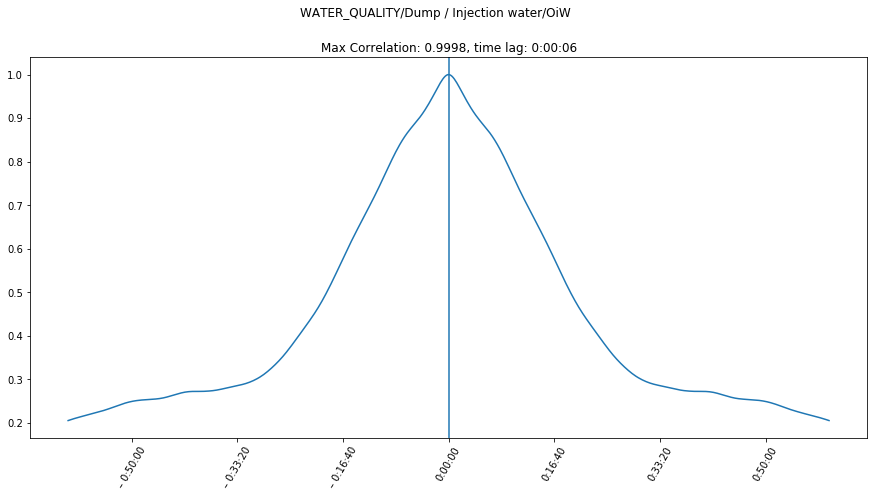

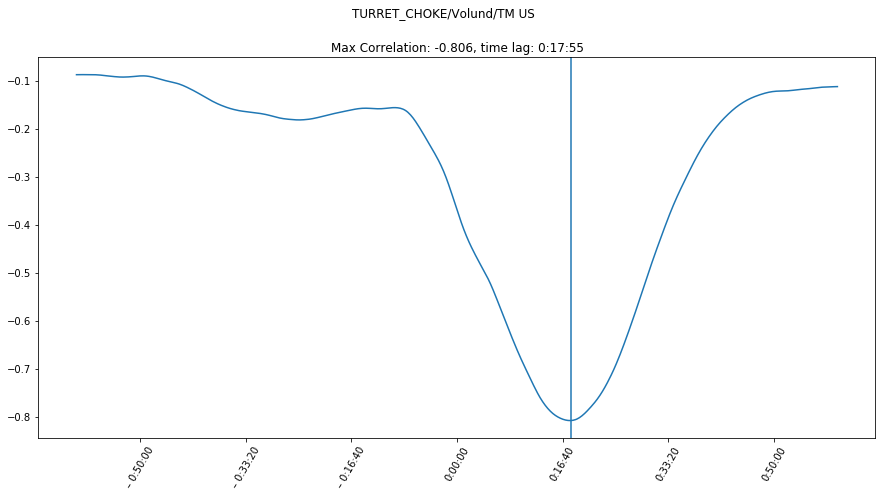

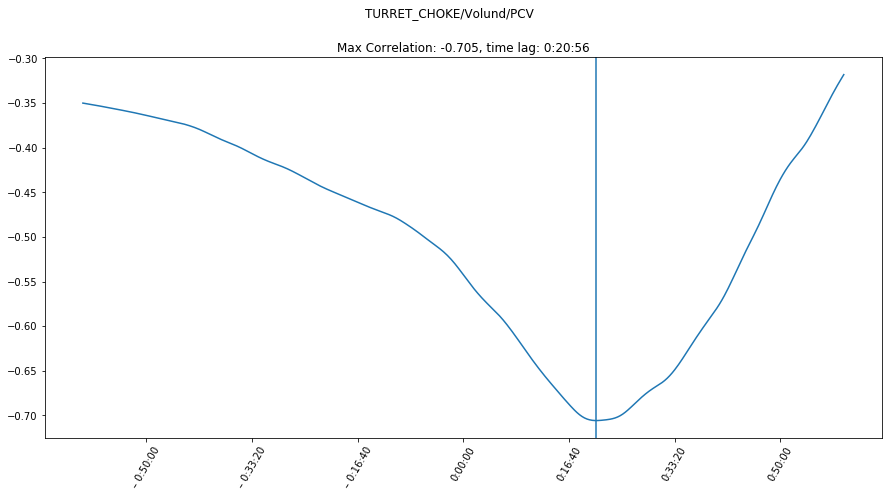

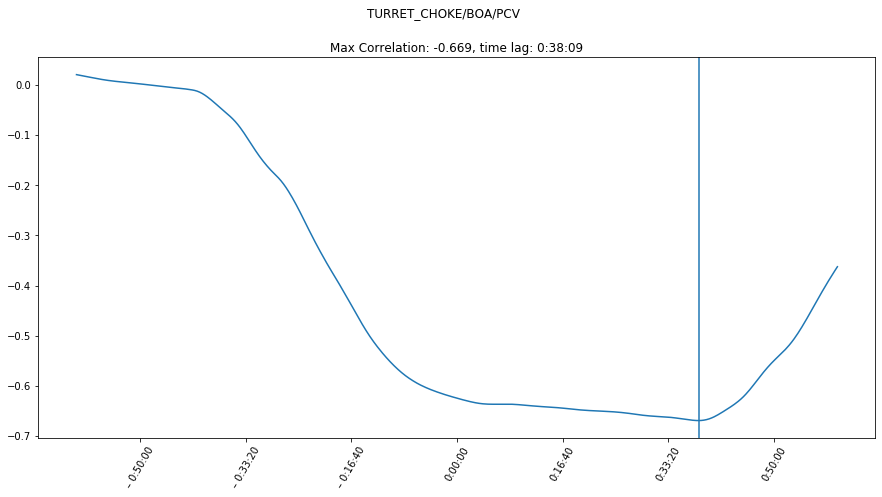

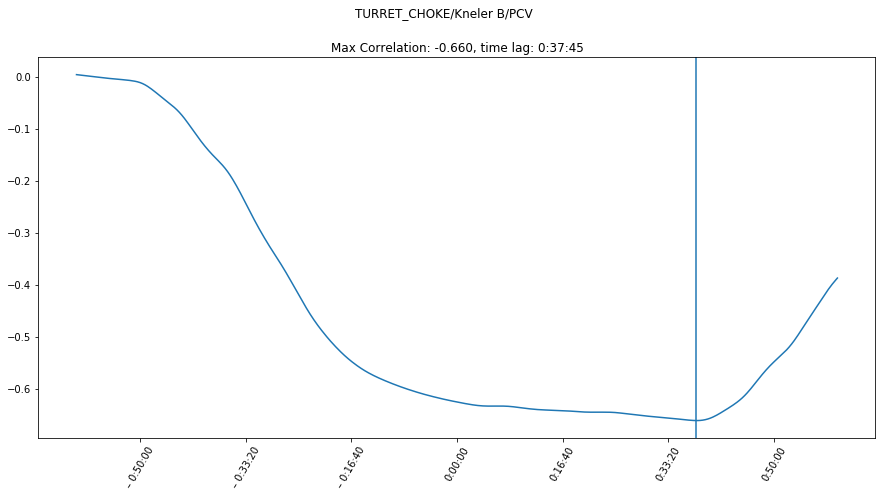

In [54]:
# Plot cross correlation over time
#print(cross)
print('Plot by iterable of indices\n')
plot_cross_correlations(cross, cols_to_plot=range(0, 3))
print('Plot by column names\n')
plot_cross_correlations(cross, cols_to_plot=['TURRET_CHOKE/BOA/PCV', 'TURRET_CHOKE/Kneler B/PCV'])
